In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp
from functools import partial
import plotting

from manifold import mirror_vecs, geodesic
from sphere import Sphere as S, proj_comp
from bures_wasserstein import BuresWasserstein as BW, BuresWassersteinN as BWN, sym


def mixture(key, x0, x1, p):
    num_dims = len(x0.shape) - 1
    shape = (x0.shape[0], *[1 for _ in range(num_dims)])
    z = jax.random.choice(
        key, jnp.array([0.0, 1.0]), shape=shape, p=jnp.array([p, 1 - p])
    )
    return z * x0 + (1.0 - z) * x1


alpha = 0.05
num_bootstrap = 500
mc_repeats = 500


@partial(jax.jit, static_argnums=(0, 1, 2))
def proc_inner(M, n, sampler, sampler_args, mu_0, key):
    x_key, fm_key, key = jax.random.split(key, 3)

    x = sampler(x_key, n, *sampler_args)
    x_mirrored = mirror_vecs(M, mu_0, x)

    mu_hat = M.frechet_mean(x, fm_key)
    t = jnp.linalg.norm(M.log(mu_0, mu_hat)) ** 2
    # t = hot_t(M, mu_0, mu_hat, x)

    def fun(it_key):
        z_key, fm_key = jax.random.split(it_key)
        x_b = mixture(z_key, x, x_mirrored, 1 / 2)
        mu_hat_b = M.frechet_mean(x_b, fm_key)
        return jnp.linalg.norm(M.log(mu_0, mu_hat_b)) ** 2

    t_b = jax.vmap(fun)(jax.random.split(key, num_bootstrap))
    return jnp.mean(t < t_b) < alpha


def eval_test_mc(M, n, sampler, sampler_args, mu_0):
    key = jax.random.PRNGKey(np.random.randint(0, 2**32))
    subkeys = jax.random.split(key, mc_repeats)
    rejects = jax.vmap(lambda key: proc_inner(M, n, sampler, sampler_args, mu_0, key))(
        subkeys
    )
    return rejects.mean(), rejects.std()

# R - Chi2

5it [00:00,  7.10it/s]


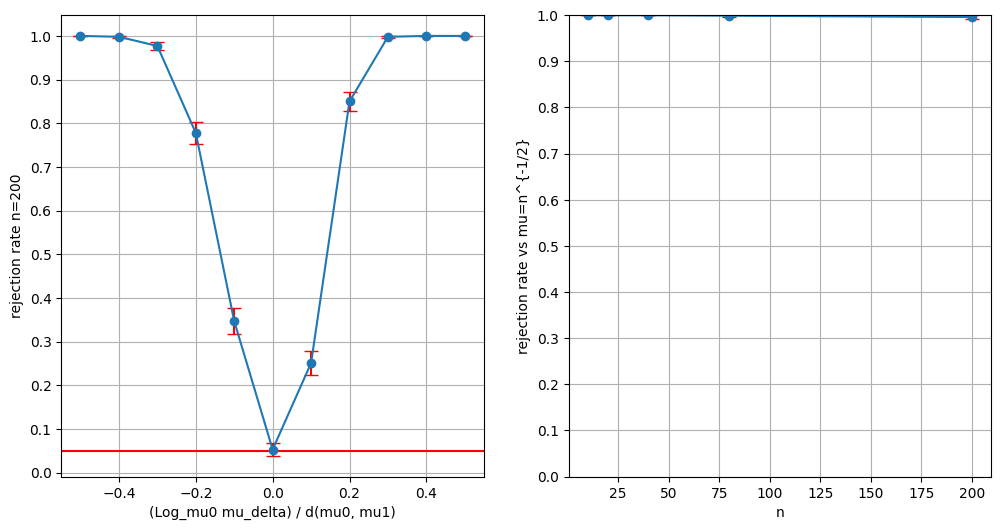

In [9]:
M = 200
b = 200
n = 200

alpha = 0.05


def proc(n, M, mu, mu_0):
    reject = np.zeros(M)
    for j in range(M):

        # N(0, 1)
        # x = np.random.randn(n) + mu

        # Chi2, standardized to E=mu, var=1
        x = (np.random.randn(n) ** 2 - 1) / np.sqrt(2) + mu
        # x0 = np.random.randn(n) / 4 - 1 / 3
        # x1 = np.random.randn(n) / 4 + 2 / 3
        # z = np.random.choice([0, 1], p=[1 / 3, 2 / 3], size=n)
        # x = z * x0 + (1 - z) * x1

        # Exp(1)
        # x = np.random.exponential(size=n) - 1 + mu

        dx = x - mu_0

        # T = d(\bar X, \mu_0)^2
        z_b = np.random.choice([-1, 1], size=(b, n))
        z_dx_mean = (z_b @ dx) / n
        t_b = np.abs(z_dx_mean) ** 2
        t = np.abs(x.mean() - mu_0) ** 2

        reject[j] = np.mean(t < t_b) < alpha
    return reject.mean(), reject.std()


# For the h/sqrt(n) alternatives, the test has power -> 1 - phi(z_{1-alpha} - h/sig) ≈ 0.99 for h/sig=4

delta_rates = np.zeros(11)
delta_rates_std = np.zeros(11)
deltas = np.linspace(-0.5, 0.5, delta_rates.shape[0])
for i, delta in tqdm(enumerate(deltas)):
    rm, rs = proc(n, mc_repeats, delta, 0)
    delta_rates[i] = rm
    delta_rates_std[i] = rs

ns = [10, 20, 40, 80, 200]
local_rates = np.zeros(len(ns))
local_rates_std = np.zeros(len(ns))
for i, n_i in tqdm(enumerate(ns)):
    rm, rs = proc(n_i, mc_repeats, 4 / np.sqrt(n_i), 0)
    local_rates[i] = rm
    local_rates_std[i] = rs

plotting.plot_sim_results(
    mc_repeats,
    n,
    deltas,
    delta_rates,
    delta_rates_std,
    ns,
    local_rates,
    local_rates_std,
)

# Wasserstein

100%|██████████| 250/250 [00:07<00:00, 34.92it/s]


size 0.036


100%|██████████| 250/250 [00:07<00:00, 34.15it/s]


power vs n^{-1/(2+eps)} 0.144


100%|██████████| 250/250 [00:06<00:00, 37.31it/s]
20it [02:21,  7.07s/it]


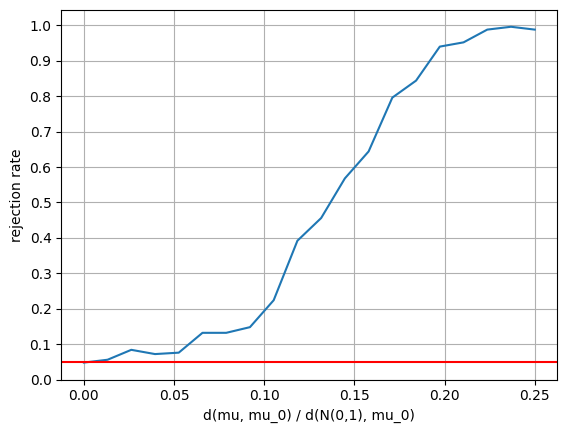

In [236]:
# grid = np.linspace(0, 1, 100)


# M = 250
# n = 200
# b = 200

# alpha = 0.05


# def noise(mu):
#     k = (1 - 2 * np.random.binomial(1, 0.5)) * np.random.randint(1, 4 + 1)
#     return mu - np.sin(np.pi * k * mu) / np.pi / abs(k)


# def inv(fx):
#     return np.interp(grid, fx, grid)


# def compose(gx, fx):  # g(f(x))
#     return np.interp(fx, grid, gx)


# def x_mirror(x, mu):
#     return 2 * mu - x


# def geodesic(x, y, t):
#     return x + (y - x) * t


# STD_NORMAL_Q = stats.norm.ppf(grid)
# STD_NORMAL_Q[0] = 2 * STD_NORMAL_Q[1] - STD_NORMAL_Q[2]  # lexp to avoid infs
# STD_NORMAL_Q[-1] = 2 * STD_NORMAL_Q[-2] - STD_NORMAL_Q[-3]  # lexp to avoid infs
# STD_NORMAL_Q -= STD_NORMAL_Q[0]
# STD_NORMAL_Q /= STD_NORMAL_Q[-1]


# def proc(M, mu, mu_0):
#     reject = np.zeros(M)
#     for j in tqdm(range(M)):
#         x = np.zeros((n, grid.shape[0]))
#         x_mirrored = np.zeros((n, grid.shape[0]))

#         for l in range(n):
#             x[l, :] = noise(mu)
#             x_mirrored[l, :] = x_mirror(x[l, :], mu_0)

#         t = np.trapz((x.mean(axis=0) - mu_0) ** 2, grid)

#         t_b = np.zeros(b)
#         for i in range(b):
#             z = np.random.choice([0, 1], size=(n, 1))
#             x_b = z * x + (1 - z) * x_mirrored
#             mu_b = x_b.mean(axis=0)
#             t_b[i] = np.trapz((mu_b - mu_0) ** 2, grid)

#         reject[j] = np.mean(t < t_b) < alpha

#     return reject.mean()


# mu_0 = grid  # id, uniform
# mu_1 = geodesic(mu_0, STD_NORMAL_Q, 1 / np.power(n, 1 / (2.1)))

# print("size", proc(M, mu_0, mu_0))
# print("power vs n^{-1/(2+eps)}", proc(M, mu_1, mu_0))

# rates = np.zeros(20)
# ts = np.linspace(0, 0.25, rates.shape[0])
# for i, t in tqdm(enumerate(ts)):
#     mu_1 = geodesic(mu_0, STD_NORMAL_Q, t)
#     rates[i] = proc(M, mu_1, mu_0)

# plt.plot(ts, rates)
# plt.axhline(0.05, color="r")
# plt.yticks(np.linspace(0, 1, 11))
# plt.xlabel("d(mu, mu_0) / d(N(0,1), mu_0)")
# plt.ylabel("rejection rate")
# plt.grid()

# Spherical Gaussian

11it [00:37,  3.38s/it]
5it [00:16,  3.22s/it]


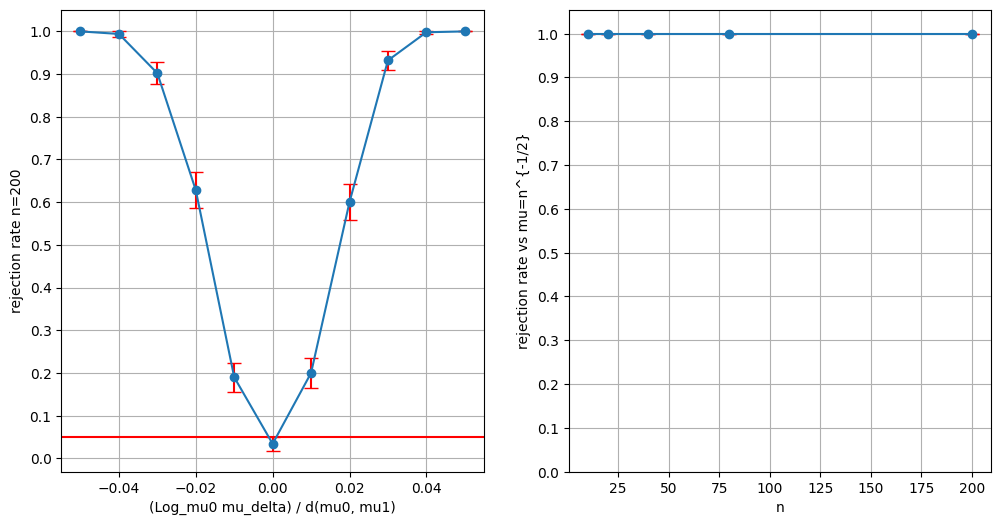

In [17]:
@partial(jax.jit, static_argnums=(1,))
def sample_von_mises(key, n, mu):
    vs = 0.2 * jax.random.normal(key, (n, mu.shape[0]))
    return jax.vmap(lambda v: S.exp(mu, proj_comp(mu, v)))(vs)


n = 200

mu_0 = jnp.array([0.0, 1.0])
mu_1 = jnp.array([1.0, 0.0])
mu_delta = lambda delta: geodesic(S, mu_0, mu_1, delta)


delta_rates = np.zeros(11)
delta_rates_std = np.zeros(11)
deltas = np.linspace(-0.05, 0.05, delta_rates.shape[0])
for i, delta in tqdm(enumerate(deltas)):
    rm, rs = eval_test_mc(S, n, sample_von_mises, (mu_delta(delta),), mu_0)
    delta_rates[i] = rm
    delta_rates_std[i] = rs

ns = [10, 20, 40, 80, 200]
local_rates = np.zeros(len(ns))
local_rates_std = np.zeros(len(ns))
for i, n_i in tqdm(enumerate(ns)):
    rm, rs = eval_test_mc(S, n, sample_von_mises, (mu_delta(1 / np.sqrt(n_i)),), mu_0)
    local_rates[i] = rm
    local_rates_std[i] = rs

plotting.plot_sim_results(
    mc_repeats,
    n,
    deltas,
    delta_rates,
    delta_rates_std,
    ns,
    local_rates,
    local_rates_std,
)

# Mixture of Spherical Gaussians

11it [00:41,  3.79s/it]
4it [00:08,  2.19s/it]


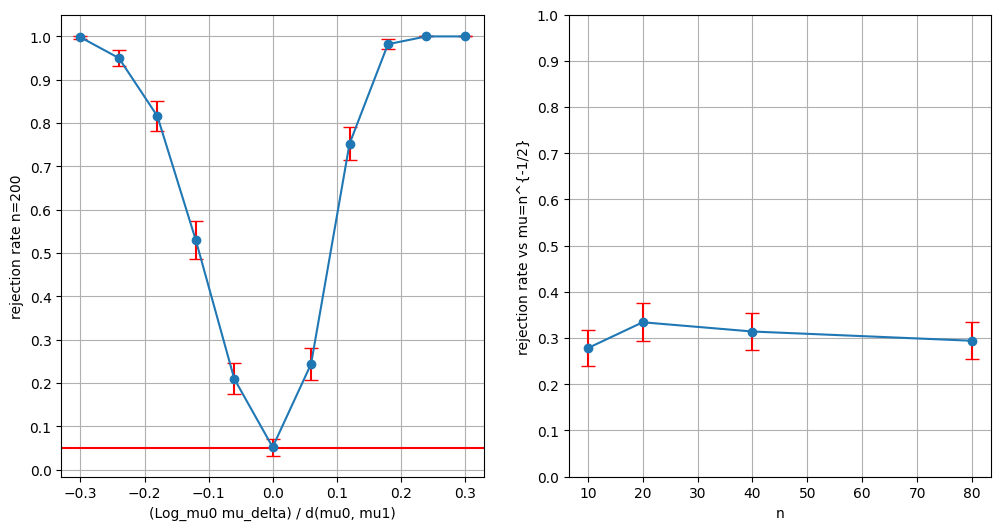

In [6]:
@partial(jax.jit, static_argnums=(1,))
def sample_mixture(key, n, mu0, mu1, p):
    key_z, key_x0, key_x1 = jax.random.split(key, 3)
    x0 = sample_von_mises(key_x0, n, mu0)
    x1 = sample_von_mises(key_x1, n, mu1)
    return mixture(key_z, x0, x1, p)


# sampling from a mixture of two gaussians with mean angles 0 and pi/2 and mixture weight 1/3
# the sample mean is then the angle pi/6
mix_mu_0 = jnp.array([0.0, 1.0])
mix_mu_1 = jnp.array([1.0, 0.0])
p = 1 / 3
mu_0 = geodesic(S, mix_mu_0, mix_mu_1, p)
mu_1 = jnp.array([1.0, 0.0])

delta_rates = np.zeros(11)
delta_rates_std = np.zeros(11)
deltas = np.linspace(-0.3, 0.3, delta_rates.shape[0])

n = 200
for i, delta in tqdm(enumerate(deltas)):
    sampler_args = (
        geodesic(S, mix_mu_0, mu_1, delta),
        geodesic(S, mix_mu_1, mu_1, delta),
        p,
    )
    rm, rs = eval_test_mc(S, n, sample_mixture, sampler_args, mu_0)
    delta_rates[i] = rm
    delta_rates_std[i] = rs

ns = [10, 20, 40, 80]
local_rates = np.zeros(len(ns))
local_rates_std = np.zeros(len(ns))
for i, n_i in tqdm(enumerate(ns)):
    delta = 1 / np.sqrt(n_i)
    sampler_args = (
        geodesic(S, mix_mu_0, mu_1, delta),
        geodesic(S, mix_mu_1, mu_1, delta),
        p,
    )
    rm, rs = eval_test_mc(S, n_i, sample_mixture, sampler_args, mu_0)
    local_rates[i] = rm
    local_rates_std[i] = rs

plotting.plot_sim_results(
    mc_repeats,
    n,
    deltas,
    delta_rates,
    delta_rates_std,
    ns,
    local_rates,
    local_rates_std,
)

(-1.1, 1.1)

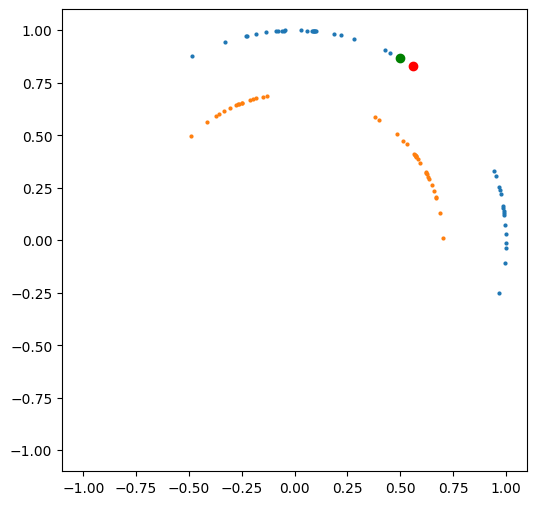

In [47]:
@partial(jax.jit, static_argnums=(1,))
def sample_mixture(key, n, mu0, mu1, p):
    key_z, key_x0, key_x1 = jax.random.split(key, 3)
    x0 = sample_von_mises(key_x0, n, mu0)
    x1 = sample_von_mises(key_x1, n, mu1)
    return mixture(key_z, x0, x1, p)


x = sample_mixture(
    jax.random.PRNGKey(np.random.randint(0, 2**32)), 40, mix_mu_0, mix_mu_1, p
)
z = mirror_vecs(S, mu_0, x)

xhat = S.frechet_mean(x, None)

plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], s=4)
plt.scatter(0.7 * z[:, 0], 0.7 * z[:, 1], s=4)
plt.scatter(xhat[0], xhat[1], color="red")
plt.scatter(mu_0[0], mu_0[1], color="green")

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

# Bures-Wasserstein

11it [01:53, 10.34s/it]
4it [00:39,  9.96s/it]


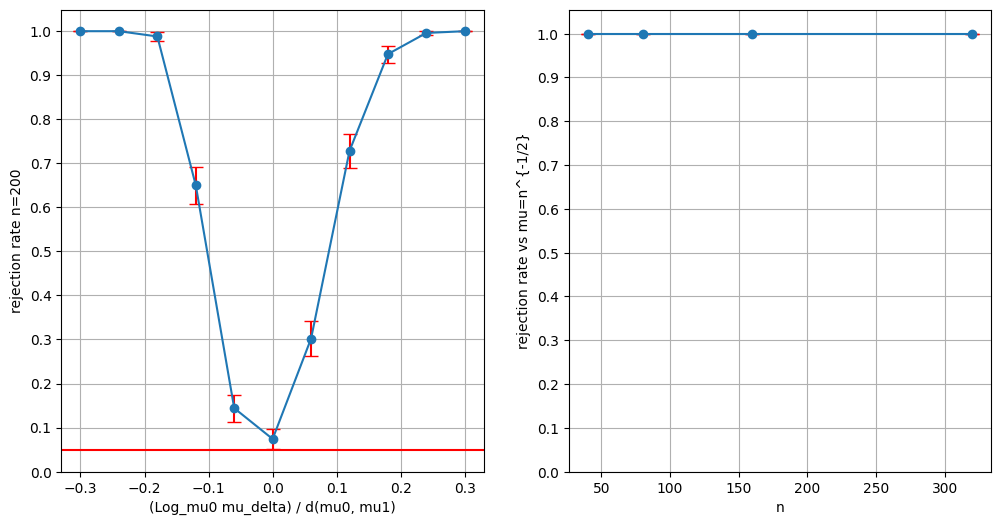

In [ ]:
@partial(jax.jit, static_argnums=(1,))
def sample(key, n, mu):
    A = jnp.sqrt(0.25) * jax.random.normal(key, (n, mu.shape[0], mu.shape[0]))
    return jax.vmap(lambda A: BW.exp(mu, sym(A)))(A)


mu_0 = jnp.eye(2)
mu_1 = jnp.array([[4, 1], [1, 3]])
mu_delta = lambda delta: geodesic(BW, mu_0, mu_1, delta)

n = 200

delta_rates = np.zeros(11)
delta_rates_std = np.zeros(11)
deltas = np.linspace(-0.3, 0.3, delta_rates.shape[0])
for i, delta in tqdm(enumerate(deltas)):
    rm, rs = eval_test_mc(BW, n, sample, (mu_delta(delta),), mu_0)
    delta_rates[i] = rm
    delta_rates_std[i] = rs


ns = [40, 80, 160, 320]
local_rates = np.zeros(len(ns))
local_rates_std = np.zeros(len(ns))
for i, n_i in tqdm(enumerate(ns)):
    rm, rs = eval_test_mc(BW, n, sample, (mu_delta(8 / np.sqrt(n_i)),), mu_0)
    local_rates[i] = rm
    local_rates_std[i] = rs


plotting.plot_sim_results(
    mc_repeats,
    n,
    deltas,
    delta_rates,
    delta_rates_std,
    ns,
    local_rates,
    local_rates_std,
)